In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import pickle
import torch
import numpy as np

from DatasetManagerLibs import DatasetConvertor, DatasetReader
from libs.TrafficPredictor.ContextAssisted import PreparingDataset as PreparingDatasetCA
from libs.TrafficPredictor.ContextAssisted import trainModelByDefaultSetting as trainModelCA
from libs.TrafficPredictor.ContextAssisted import evaluateModel as evaluateModelCA
from libs.TrafficPredictor.ContextAssisted import createModel as createModelCA
from PredictorConfigs import getPredictorConfig, visualizeEnvConfig

In [8]:
datasetReader = DatasetReader(parentFolder="../Dataset")
datasetConverter = DatasetConvertor()
datasetLabel = "Task0_1_2"
for taskName in ["Task0", "Task1", "Task2"]:
    for fileIndex in datasetReader.readFileIndexsList:
        datasetReader.readRawDataset(f"../Dataset/{taskName}/exp{fileIndex}/motion.txt", datasetLabel=datasetLabel)

In [9]:
configIdx = 0
config = getPredictorConfig(configIdx)

lenWindow = config['LEN_window']
upsampleK = config['upsampleK']
dataflow = config['dataflow']
dbParameter = config['dbParameter']
alpha = config['alpha']
mode = config['mode']
direction = config['direction']
train_ratio = config['train_ratio']
trainDataAugment = config['trainDataAugment']
smoothFc = config['smoothFc']
smoothOrder = config['smoothOrder']
visualizeEnvConfig(config)


Predictor Configuration
Window Length:          200
Upsample K:             10
Dataflow:               thumb_fr
DB Parameter:           0.001
Alpha:                  0.01
Mode:                   fixed
Direction:              forward
Train Ratio:            0.6
Train Data Augment:     False
Smooth Fc:              1.5
Smooth Order:           3


In [10]:
datasetConverter.registerDataUnit(datasetReader.dfLibrary[datasetLabel])
datasetConverter.generateTrafficByDpdr(dbParameter=dbParameter, alpha=alpha, mode=mode, direction=direction, upsampleK=upsampleK)

========== thumb ============
Forward: Compression rate:0.2725844439255435
========== index ============
Forward: Compression rate:0.2921441276265758
========== middle ============
Forward: Compression rate:0.29505573861228584


In [11]:
datUnit = datasetConverter.getDataUnit(dataflow)

print(f"================== lenWindow = {lenWindow} =================")
trainDataAugment = False
verbose = True

paramsCA = {}
paramsCA['lenSource'] = lenWindow
paramsCA['lenTarget'] = lenWindow
paramsCA['trainRatio'] = train_ratio
paramsCA['dataAugment'] = trainDataAugment
paramsCA['smoothFc'] = smoothFc
paramsCA['smoothOrder'] = smoothOrder
paramsCA['contextDownsample'] = upsampleK

#============= Training =============
trainData, testData, (newLenSource, newLenTarget) = PreparingDatasetCA(datUnit, paramsCA, verbose=verbose)
(contextSrc, contextTrg, _, trafficSrc, trafficTrg, _, transmissionsVector, contextSrcNoSmooth) = trainData
print(f"Context Source shape: {contextSrc.shape}")
print(f"Context Target shape: {contextTrg.shape}")
print(f"Traffic Source shape: {trafficSrc.shape}")
print(f"Traffic Target shape: {trafficTrg.shape}")
print(f"Transmissions Vector shape: {transmissionsVector.shape}")
print(f"Context Source No Smooth shape: {contextSrcNoSmooth.shape}")

if  paramsCA['contextDownsample'] is not None:
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    newLenSource, newLenTarget, trainData, testData, verbose=verbose)
else:
    bestWeightsCA, _, _, modleParametersCA = trainModelCA(
    paramsCA['lenSource'], paramsCA['lenTarget'], trainData, testData, verbose=verbose)

#============= Evaluatation =============
trafficModelCA, _ = createModelCA(modleParametersCA)
trafficModelCA.load_state_dict(bestWeightsCA)
paramsValid = paramsCA.copy()
paramsValid['dataAugment'] = False
trainData, testData, (newLenSource, newLenTarget) = PreparingDatasetCA(datUnit, paramsValid, verbose=verbose)
resultsTrain = evaluateModelCA(trafficModelCA, trainData)
resultsTest = evaluateModelCA(trafficModelCA, testData)
    

================== lenWindow = 200 =================
Train size: 624396, Test size: 416265
Context Source shape: (3120, 20, 3)
Context Target shape: (3120, 20, 3)
Traffic Source shape: (3120, 1)
Traffic Target shape: (3120, 1)
Transmissions Vector shape: (3120, 20)
Context Source No Smooth shape: (3120, 20, 3)
Size of train loader: 1, Size of test loader: 1
Used device: cuda
Size of model: 31756
TrafficPredictorContextAssisted(
  (dbf2traffic): DeadFeaturesToTrafficLayer(
    (input_layer): Sequential(
      (0): Linear(in_features=231, out_features=64, bias=True)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.8, inplace=False)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.8, inplac

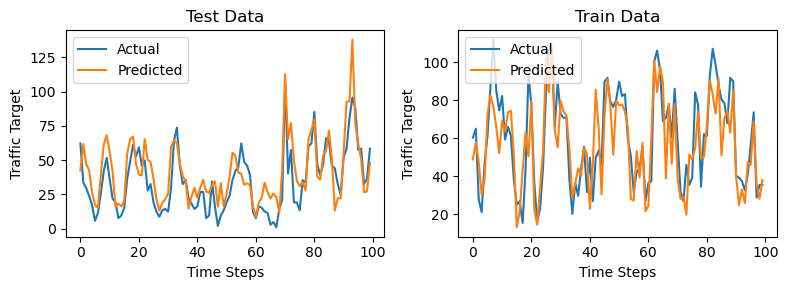

In [12]:
def UpsampleTraffic(traffic, lenWindow,upsampleK):
    return np.interp(
        traffic,
        np.linspace(0, np.floor(lenWindow/upsampleK+1).astype(int), num=lenWindow+1),
        np.linspace(0, lenWindow+1, num=lenWindow+1)
    )

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Test data plot
ax1.plot(UpsampleTraffic(resultsTest['trafficTarget_actual'][0:100], lenWindow, upsampleK), label='Actual')
ax1.plot(UpsampleTraffic(resultsTest['trafficTarget_predicted'][0:100], lenWindow, upsampleK), label='Predicted')
ax1.set_title('Test Data')
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Traffic Target')
ax1.legend()

# Train data plot
ax2.plot(UpsampleTraffic(resultsTrain['trafficTarget_actual'][0:100], lenWindow, upsampleK), label='Actual')
ax2.plot(UpsampleTraffic(resultsTrain['trafficTarget_predicted'][0:100], lenWindow, upsampleK), label='Predicted')
ax2.set_title('Train Data')
ax2.set_xlabel('Time Steps')
ax2.set_ylabel('Traffic Target')
ax2.legend()

plt.tight_layout()
plt.show()
#============= Save Results =============
with open(f"Results/TrafficPredictor/evaluate/{datasetLabel}_{lenWindow}_train.pkl", "wb") as file:
    pickle.dump(resultsTrain, file)
with open(f"Results/TrafficPredictor/evaluate/{datasetLabel}_{lenWindow}_test.pkl", "wb") as file:
    pickle.dump(resultsTest, file)
with open(f"Results/TrafficPredictor/modelParams/{datasetLabel}_{lenWindow}.pkl", "wb") as file:
    pickle.dump(modleParametersCA, file)
torch.save(bestWeightsCA, f"Results/TrafficPredictor/model/{datasetLabel}_{lenWindow}.pth")